In [522]:
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split , cross_val_score, cross_validate ,GridSearchCV,RepeatedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Reading Spotify tracks dataset in chunks

In [523]:
start = time.time()
#read data in chunks of 10k rows at a time
chunks_tracks = pd.read_csv("spotify_tracks.csv",chunksize=10000)
end = time.time()
print("Read csv files with chunks: ",(end-start),"sec")
tracks = pd.concat(chunks_tracks)

Read csv files with chunks:  0.08895707130432129 sec


In [3]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


### Data Pre-processing and Exploration

In [9]:
tracks.info()
#no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [524]:
def join_artists(list_artists:list):
    "function for making artists list a string that's practically one artist for our analysis"
    new = ' & '.join(str(x) for x in list_artists)
    return new

Converting the "artists" feature to a Python attribute - list and not object

In [525]:
tracks["list_artists"] = tracks["artists"].apply(eval)

In [526]:
tracks["joined_artists"] = tracks["list_artists"].apply(lambda x: join_artists(x))

In [527]:
tracks['release_year'] = tracks["release_date"].str[:4]

In [528]:
def year_to_decade(year: int) -> str:
    'function that gets year as input and returns decade'
    decade = math.floor(int(year) / 10) * 10
    return f"{decade}s"

In [529]:
tracks["decade"] = tracks["release_year"].apply(lambda x: year_to_decade(x))

In [530]:
#number of collaborating artists in track
tracks["collabs"] = tracks['list_artists'].apply(lambda x: len(x))

In [11]:
tracks.groupby(['joined_artists'])['popularity'].mean().reset_index().sort_values(by='popularity', ascending=False).head(20)

,joined_artists,popularity
84491,Riton & Nightcrawlers & Mufasa & Hypeman & Dop...,94.0
60428,Los Legendarios & Wisin & Jhay Cortez,94.0
9703,Bad Bunny & ROSALÍA,93.0
72105,Nathan Evans & 220 KID & Billen Ted,92.0
62775,MEDUZA & Dermot Kennedy,92.0
85023,Rochy RD & Myke Towers & Nicki Nicole,92.0
101979,Travis Scott & HVME,92.0
9693,Bad Bunny & Jhay Cortez,91.0
88516,Saweetie & Doja Cat,90.0
65678,Maroon 5 & Megan Thee Stallion,90.0


In [356]:
tracks['popularity'].value_counts().reset_index()
pop_freq = tracks['popularity'].value_counts().reset_index().rename(columns={'index': 'Popularity','popularity':'Frequency'}).sort_values(by='Popularity', ascending=True)

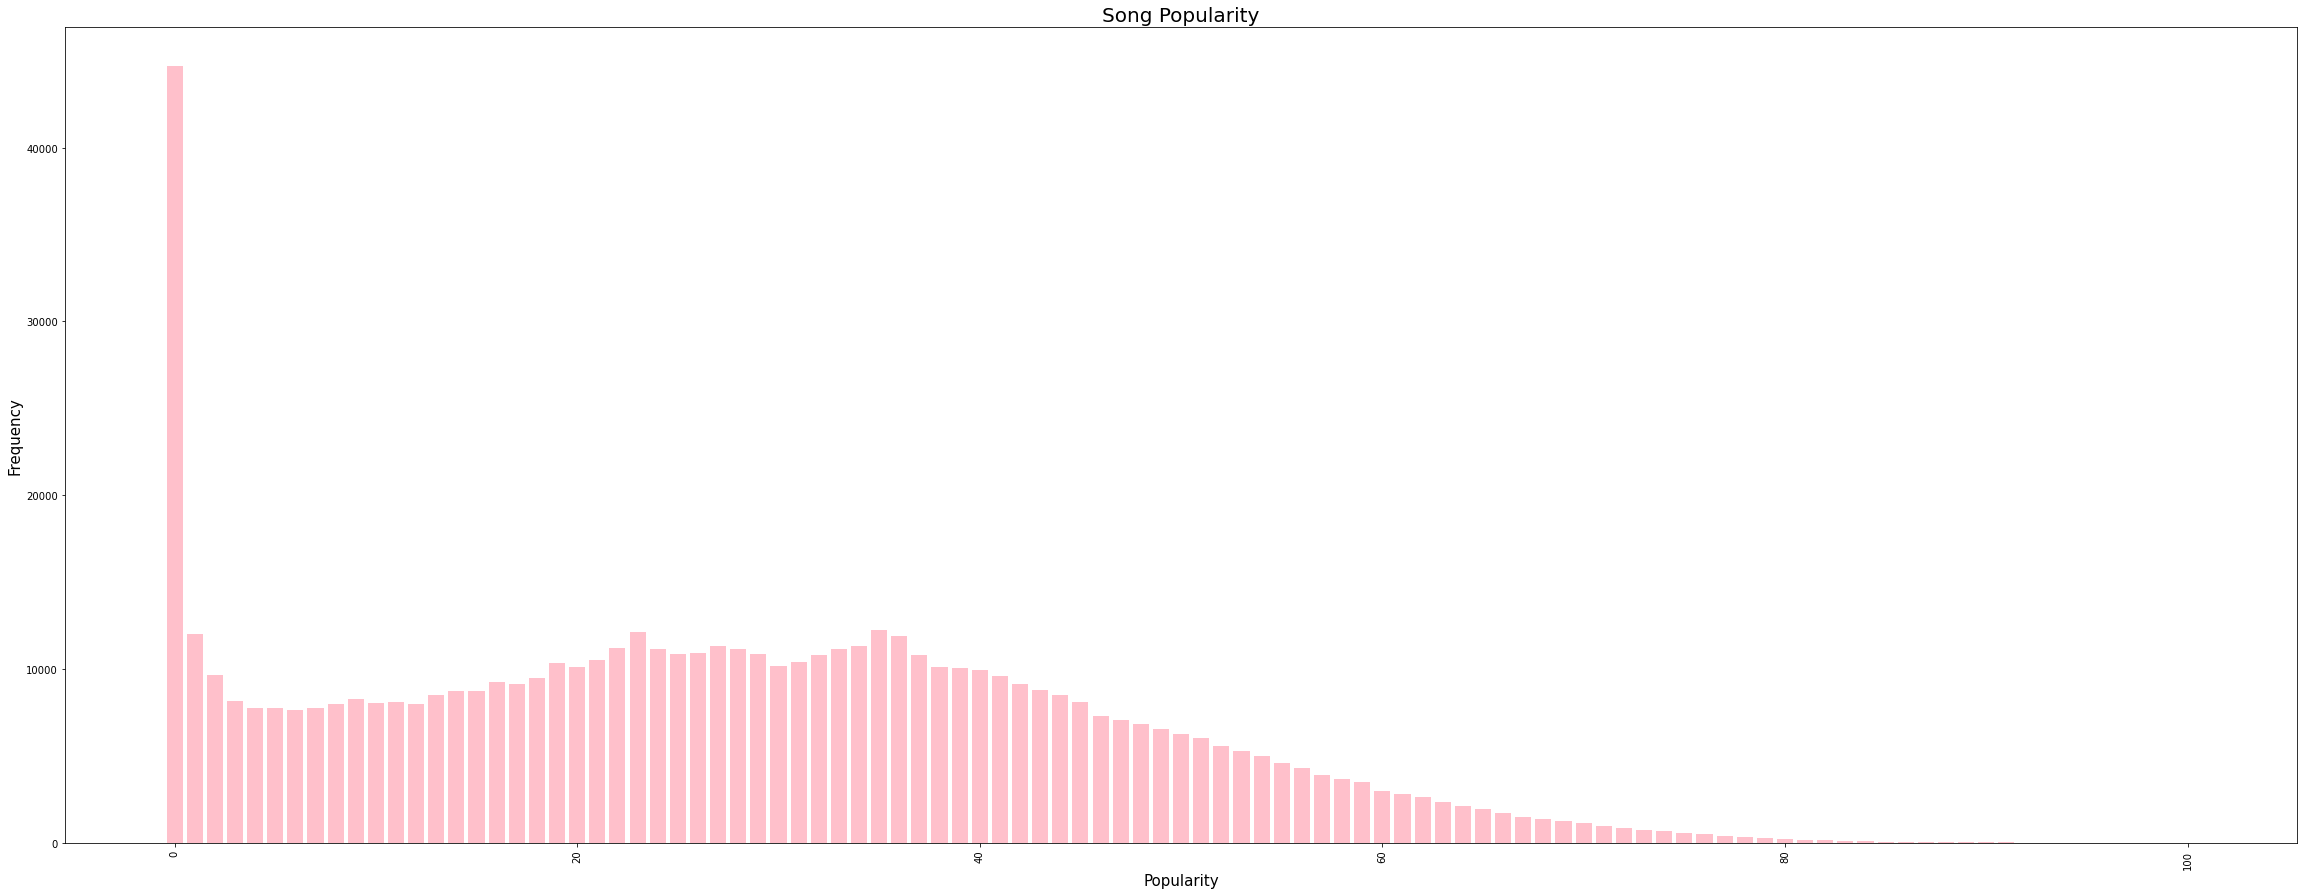

In [357]:
plt.figure(figsize=(40,15))
width = 0.8
plt.bar(pop_freq["Popularity"],pop_freq["Frequency"],width,color = "pink")
plt.xticks(rotation=90)
plt.xlabel("Popularity",size=15,color="black")
plt.ylabel("Frequency",size=15,color="black")
plt.title("Song Popularity",fontsize=20,color="black")
plt.show()

 First data filter - filtering songs below 10 popularity score:

In [531]:
tracks = tracks[tracks['popularity'] >= 10]  

In [359]:
tracks['popularity'].value_counts().reset_index()
high_pop_freq = tracks['popularity'].value_counts().reset_index().rename(columns={'index': 'Popularity','popularity':'Frequency'}).sort_values(by='Popularity', ascending=True)

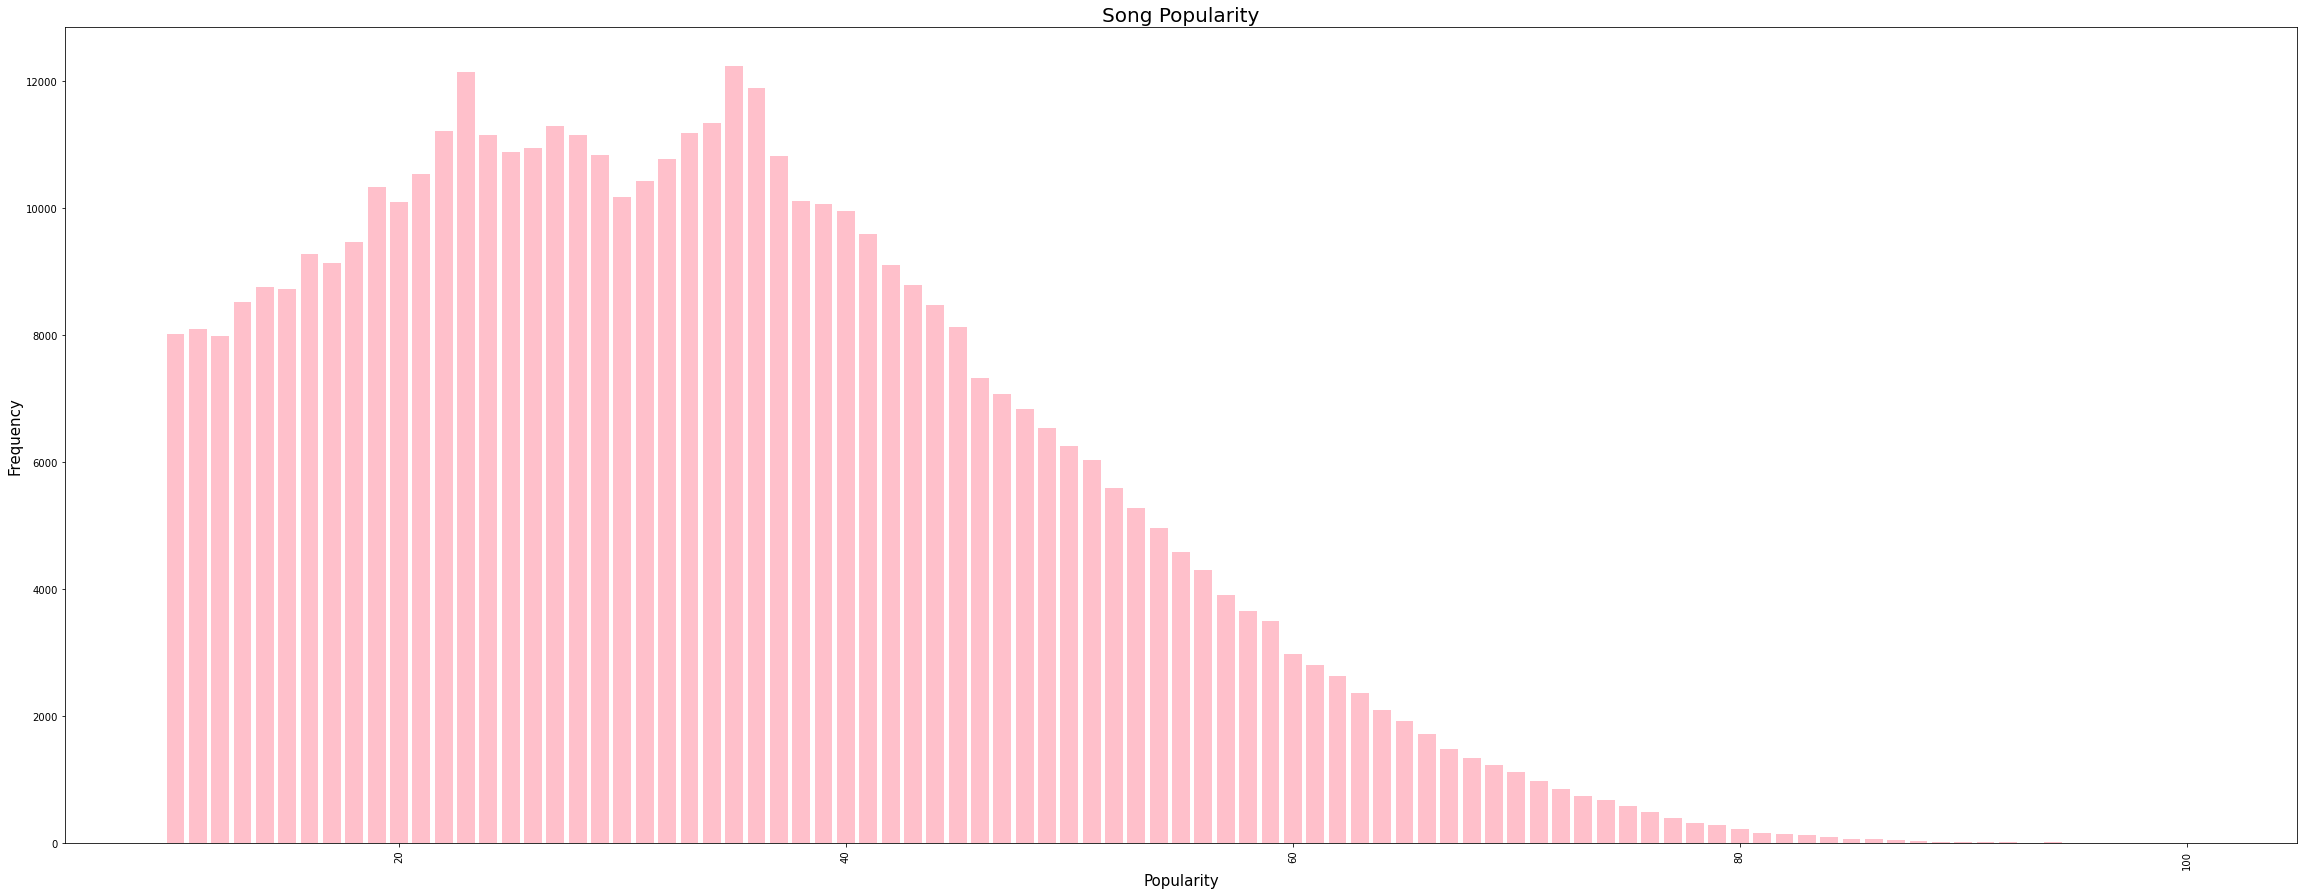

In [360]:
plt.figure(figsize=(40,15))
width = 0.8
plt.bar(high_pop_freq["Popularity"],high_pop_freq["Frequency"],width,color = "pink")
plt.xticks(rotation=90)
plt.xlabel("Popularity",size=15,color="black")
plt.ylabel("Frequency",size=15,color="black")
plt.title("Song Popularity",fontsize=20,color="black")
plt.show()

In [532]:
def popular_or_not(popularity:int,thresh:int):
    "function that sets rule for popularity binary classification"
    if popularity>=thresh:
        popularity = 1
    else:
        popularity = 0
    return popularity

In [533]:
tracks =df_highPop

In [534]:
tracks["pop_or_not"] = tracks["popularity"].apply(lambda x: popular_or_not(x,70))

In [364]:
pop_groupby = tracks.groupby(['joined_artists'])

In [128]:
Grpd = pop_groupby.agg({'explicit': 'mean','danceability':'mean','energy':'mean','loudness':'mean', 'mode':'mean','popularity':'mean','pop_or_not':'mean'}).reset_index().sort_values(by='popularity', ascending=False)

In [25]:
Grpd.head(50)

,joined_artists,explicit,danceability,energy,loudness,mode,popularity,pop_or_not
84491,Riton & Nightcrawlers & Mufasa & Hypeman & Dop...,0.0,0.8240,0.862,-3.424,1.0,94.0,1.0
60428,Los Legendarios & Wisin & Jhay Cortez,0.0,0.8490,0.701,-4.407,0.0,94.0,1.0
9703,Bad Bunny & ROSALÍA,0.0,0.8560,0.618,-4.892,1.0,93.0,1.0
72105,Nathan Evans & 220 KID & Billen Ted,0.0,0.7220,0.893,-3.255,0.0,92.0,1.0
62775,MEDUZA & Dermot Kennedy,0.0,0.6320,0.595,-7.644,0.0,92.0,1.0
85023,Rochy RD & Myke Towers & Nicki Nicole,0.0,0.5850,0.611,-4.132,1.0,92.0,1.0
101979,Travis Scott & HVME,1.0,0.8410,0.593,-7.846,1.0,92.0,1.0
9693,Bad Bunny & Jhay Cortez,1.0,0.7310,0.573,-10.059,0.0,91.0,1.0
88516,Saweetie & Doja Cat,1.0,0.8400,0.766,-4.120,1.0,90.0,1.0
65678,Maroon 5 & Megan Thee Stallion,0.0,0.7130,0.676,-5.483,1.0,90.0,1.0


Generating Wordcloud of top artists by popularity

In [43]:
popular_artists = Grpd.head(30)['joined_artists'].tolist()
frequencies_ones = [1] * len(popular_artists)

NameError: name 'Grpd' is not defined

In [535]:
import matplotlib.pyplot as plt
import wordcloud as w

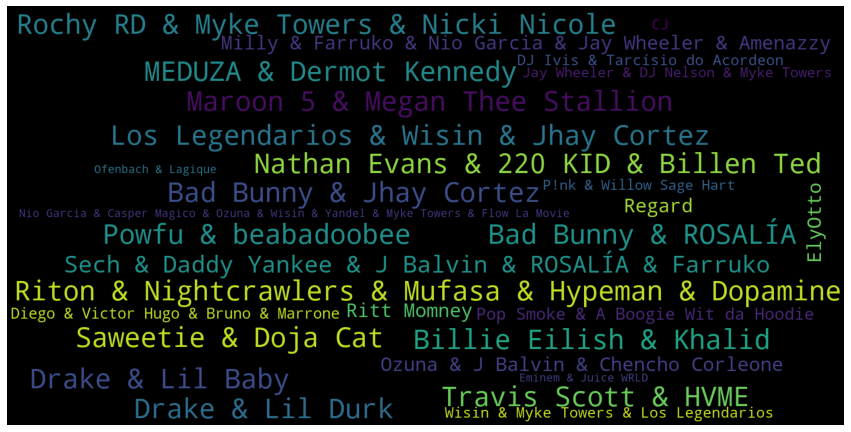

In [28]:
d = dict(zip(popular_artists, frequencies_ones))
wordcloud = w.WordCloud(collocations=False,width=1600,height=800).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

In [29]:
words=(" & ").join(Grpd.head(50)['joined_artists'].tolist())
with open('words.txt', 'w',encoding="utf-8") as f:
    f.write(words)

In [30]:
pip install stylecloud

Note: you may need to restart the kernel to use updated packages.


In [31]:
import stylecloud

In [32]:
stylecloud.gen_stylecloud(file_path = "words.txt", icon_name= "fab fa-spotify", palette="cartocolors.diverging.TealRose_7", background_color="black")

Frequency of songs each year

In [536]:
years = tracks["release_date"].str[:4]

In [537]:
years_freq = years.value_counts().reset_index().rename(columns={'index': 'Release Year','release_date':'Frequency'}).sort_values(by='Release Year', ascending=True)

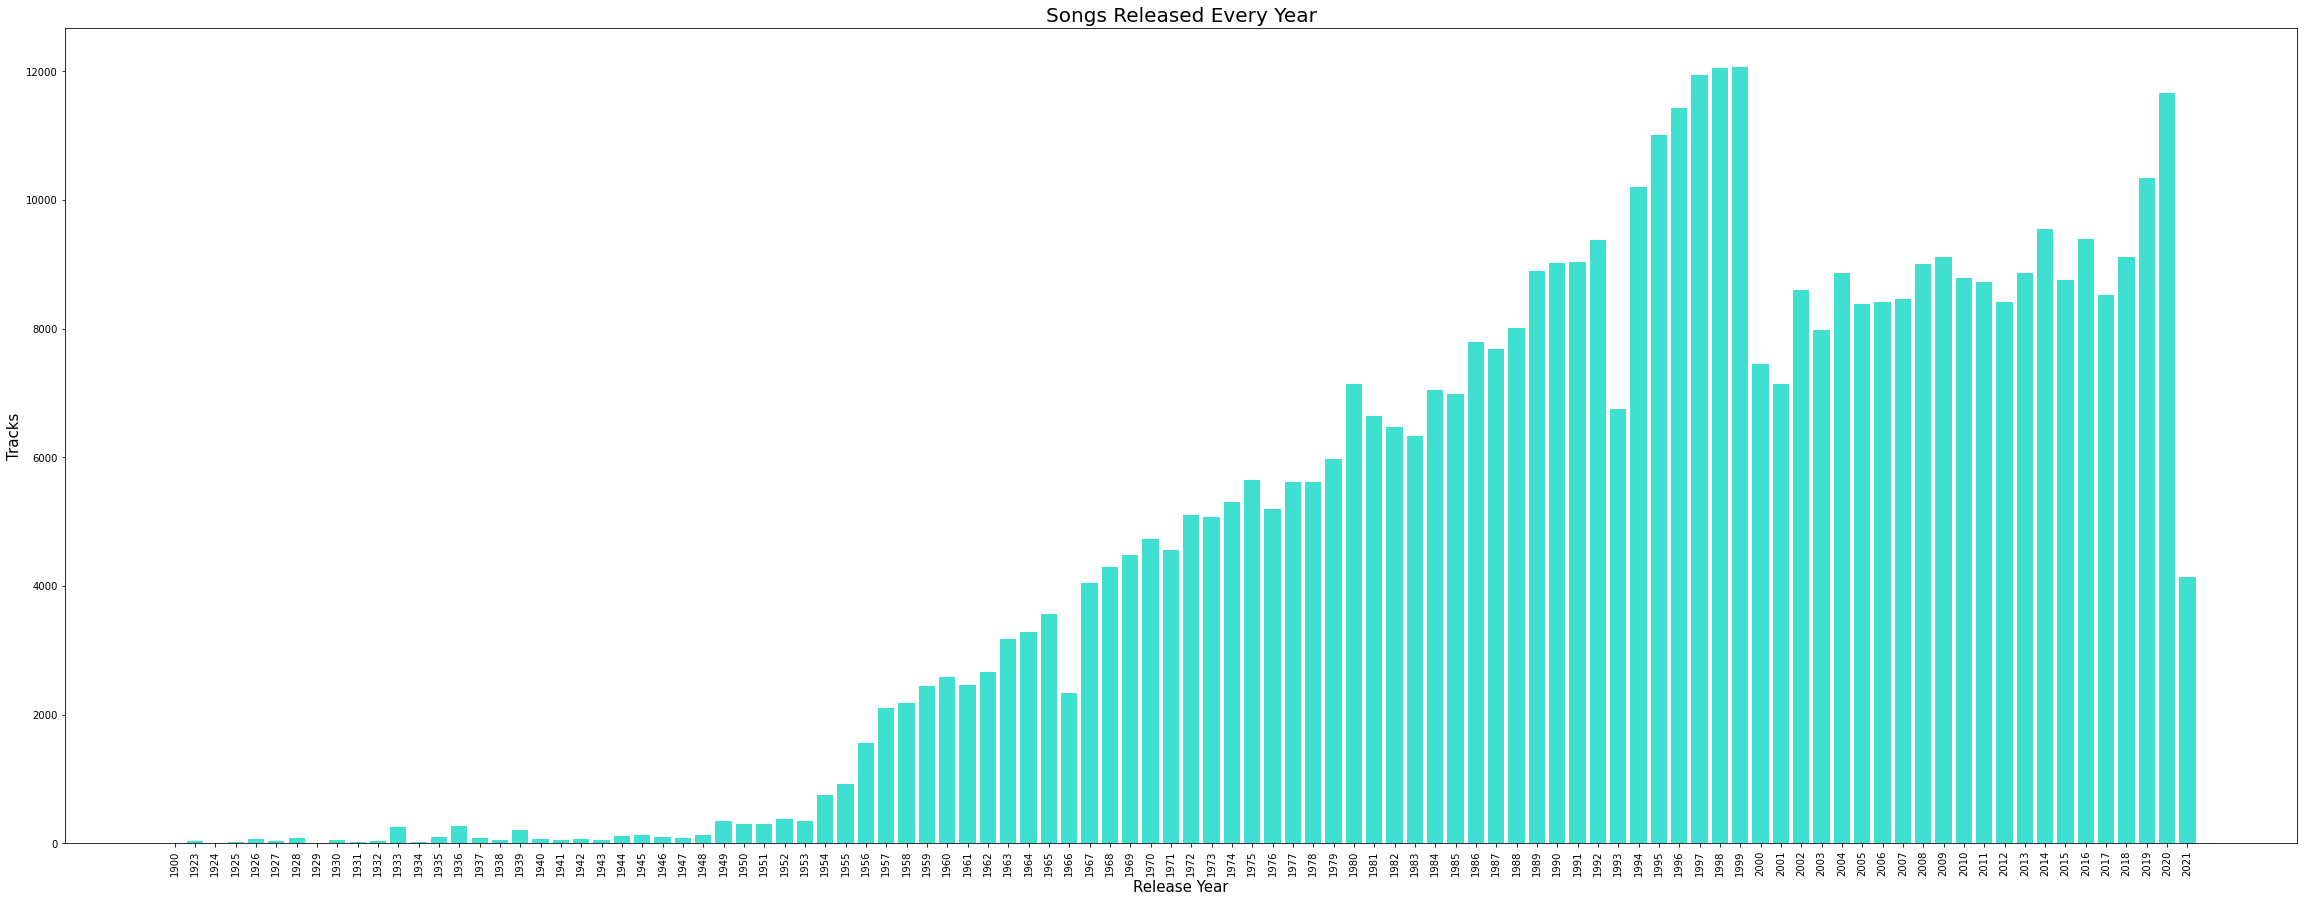

In [367]:
plt.figure(figsize=(40,15))
width = 0.8
plt.bar(years_freq["Release Year"],years_freq["Frequency"],width,color = "turquoise")
plt.xticks(rotation=90)
plt.xlabel("Release Year",size=15,color="black")
plt.ylabel("Tracks",size=15,color="black")
plt.title("Songs Released Every Year",fontsize=20,color="black")
plt.show()

In [368]:
tracks['release_date'].value_counts()

1995          2770
1997          2754
1997-01-01    2708
1998-01-01    2707
1998          2672
              ... 
1971-06-12       1
1969-01-27       1
1962-04-04       1
1965-09-11       1
1987-04-11       1
Name: release_date, Length: 18125, dtype: int64

In [38]:
a = tracks['release_date'].apply(lambda x: len(x))

In [121]:
a.value_counts()

10    448081
4     136489
7       2102
Name: release_date, dtype: int64

In [39]:
decade_groupby = tracks.groupby(['decade'])['popularity'].max()

In [40]:
tracks.groupby(['decade'])['popularity'].max()

decade
1900s     19
1920s     55
1930s     65
1940s     69
1950s     77
1960s     83
1970s     86
1980s     86
1990s     83
2000s     87
2010s     94
2020s    100
Name: popularity, dtype: int64

<AxesSubplot:xlabel='danceability', ylabel='popularity'>

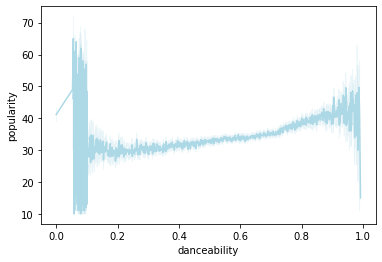

In [540]:
sns.lineplot(x='danceability', y='popularity',  data=tracks,color='lightblue')

<AxesSubplot:xlabel='danceability', ylabel='energy'>

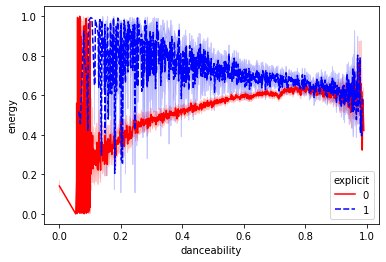

In [541]:
sns.lineplot(x='danceability', y='energy',  data=tracks,hue='explicit',style='explicit',palette=['r', 'b'])

<AxesSubplot:xlabel='danceability', ylabel='valence'>

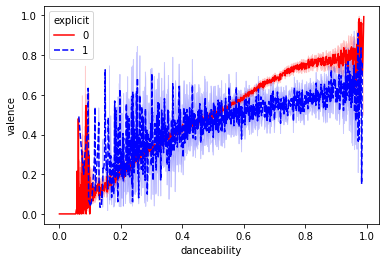

In [542]:
sns.lineplot(x='danceability', y='valence',  data=tracks,hue='explicit',style='explicit',palette=['r', 'b'])

<AxesSubplot:xlabel='energy', ylabel='acousticness'>

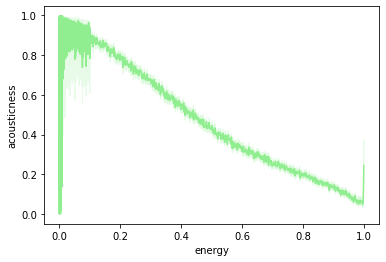

In [543]:
sns.lineplot(x='energy', y='acousticness',  data=tracks,color = 'lightgreen')

<AxesSubplot:xlabel='danceability', ylabel='acousticness'>

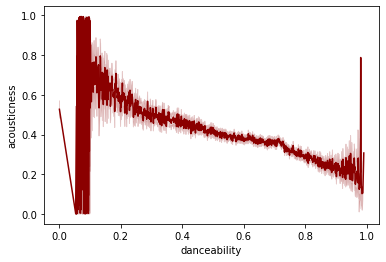

In [544]:
sns.lineplot(x='danceability', y='acousticness',  data=tracks,color = 'darkred')

<AxesSubplot:xlabel='explicit', ylabel='popularity'>

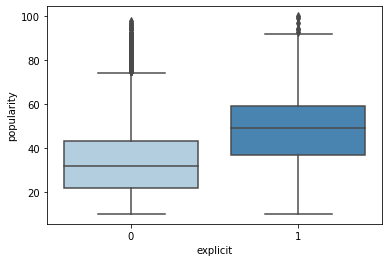

In [546]:
sns.boxplot(x='explicit', y='popularity', data=tracks, palette="Blues")

<AxesSubplot:xlabel='mode', ylabel='popularity'>

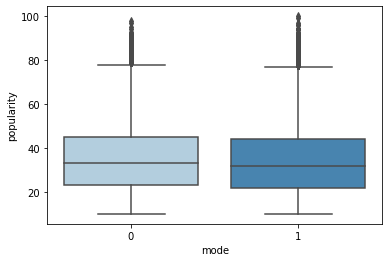

In [548]:
sns.boxplot(x='mode', y='popularity', data=tracks, palette = "Blues")

## Models

In [369]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465064 entries, 149 to 586671
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                465064 non-null  object 
 1   name              465061 non-null  object 
 2   popularity        465064 non-null  int64  
 3   duration_ms       465064 non-null  int64  
 4   explicit          465064 non-null  int64  
 5   artists           465064 non-null  object 
 6   id_artists        465064 non-null  object 
 7   release_date      465064 non-null  object 
 8   danceability      465064 non-null  float64
 9   energy            465064 non-null  float64
 10  key               465064 non-null  int64  
 11  loudness          465064 non-null  float64
 12  mode              465064 non-null  int64  
 13  speechiness       465064 non-null  float64
 14  acousticness      465064 non-null  float64
 15  instrumentalness  465064 non-null  float64
 16  liveness          

In [549]:
data = tracks.drop(['id','name','artists', 'id_artists', 'list_artists','joined_artists','key','release_date','release_year'], axis=1)

In [550]:
def trim_str(word):
    word = word[:-1]
    return word

In [551]:
data["decade"] = data["decade"].apply(lambda x: trim_str(x)).apply(eval)

In [552]:
data = data[data["decade"]>=1990].drop(["decade"],axis=1)

In [553]:
len(data)

292584

In [21]:
#data = pd.get_dummies(data,prefix=["time_signature","decade","collabs"],columns=["time_signature","decade","collabs"],drop_first=True)

In [130]:
#data = pd.get_dummies(data,columns=["time_signature"],drop_first=True)

To avoid the dummy variable trap, we passed "drop_first" to the function. 

(Regarding the decade variable that was removed (1900s) - there's only one track from the 1900s, so this is a feature that can be dropped anyway).

UPDATE: We will not use dummy variables beacause this increases the data's dimension significantly

In [375]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292584 entries, 39501 to 586671
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        292584 non-null  int64  
 1   duration_ms       292584 non-null  int64  
 2   explicit          292584 non-null  int64  
 3   danceability      292584 non-null  float64
 4   energy            292584 non-null  float64
 5   loudness          292584 non-null  float64
 6   mode              292584 non-null  int64  
 7   speechiness       292584 non-null  float64
 8   acousticness      292584 non-null  float64
 9   instrumentalness  292584 non-null  float64
 10  liveness          292584 non-null  float64
 11  valence           292584 non-null  float64
 12  tempo             292584 non-null  float64
 13  time_signature    292584 non-null  int64  
 14  collabs           292584 non-null  int64  
 15  pop_or_not        292584 non-null  int64  
dtypes: float64(9), i

In [554]:
X, y1 ,y2 = data.drop(['pop_or_not','popularity'],axis=1), data.iloc[:,15].values, data.iloc[:,0].values

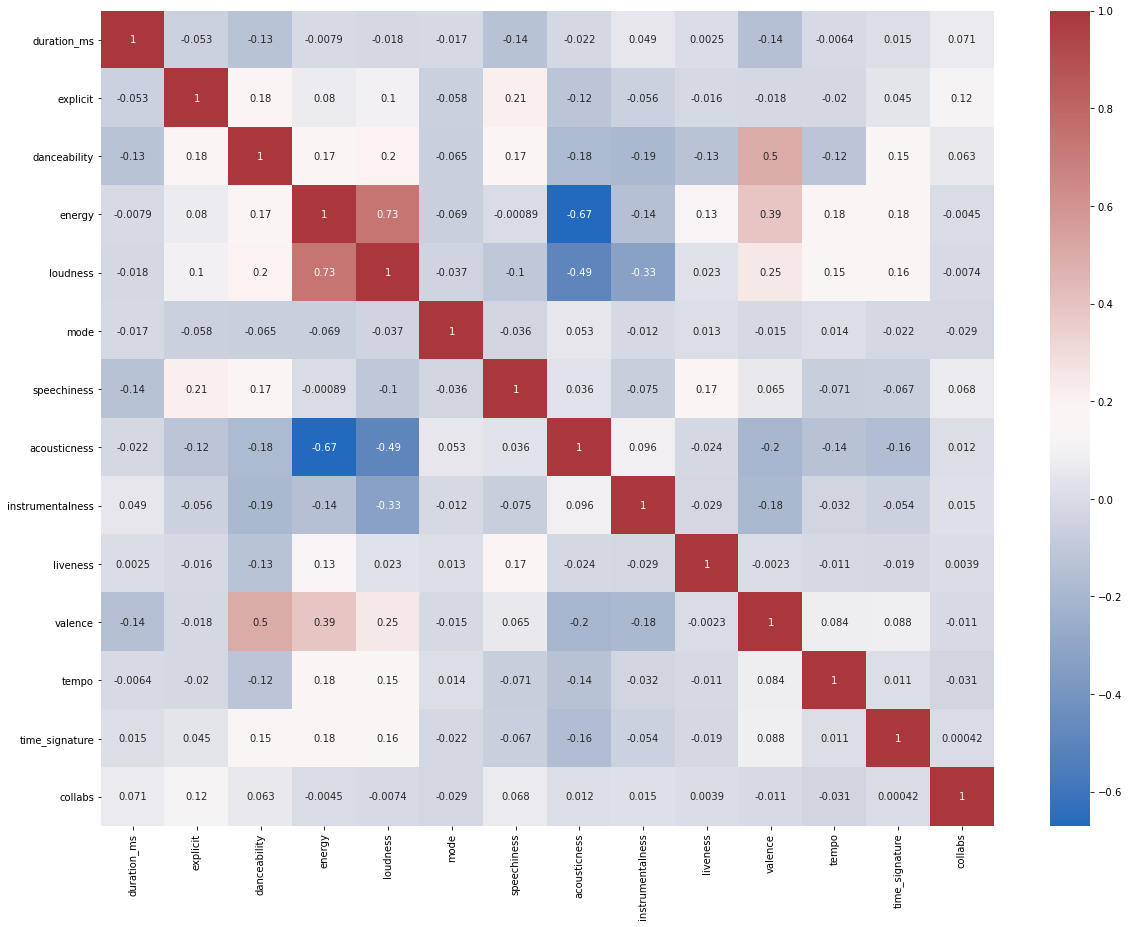

In [438]:
corrMatrix = X.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corrMatrix, annot=True,cmap='vlag')
plt.show()

In [555]:
def VIF_check(X):
    'Variance inflation factor - for checking multicollinearity'
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
# calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    return vif_data

def backwardElimination(X, y, Sig_level):
    '#feature-selection - B.E'
    X_arr = X.values
    names = X.columns.tolist()    
    num_of_vars = len(X_arr[0])
    for i in range(0, num_of_vars):
        regressor_OLS = sm.OLS(y, X_arr).fit()
        highest_SL = max(regressor_OLS.pvalues).astype(float)
        if highest_SL > Sig_level:
            for j in range(0, num_of_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == highest_SL):
                    X_arr = np.delete(X_arr, j, 1)
                    del names[j]
                    break
    regressor_OLS.summary()
    return X_arr, names

In [381]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292584 entries, 39501 to 586671
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       292584 non-null  int64  
 1   explicit          292584 non-null  int64  
 2   danceability      292584 non-null  float64
 3   energy            292584 non-null  float64
 4   loudness          292584 non-null  float64
 5   mode              292584 non-null  int64  
 6   speechiness       292584 non-null  float64
 7   acousticness      292584 non-null  float64
 8   instrumentalness  292584 non-null  float64
 9   liveness          292584 non-null  float64
 10  valence           292584 non-null  float64
 11  tempo             292584 non-null  float64
 12  time_signature    292584 non-null  int64  
 13  collabs           292584 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 33.5 MB


In [556]:
VIF_check(X)

,feature,VIF
0,duration_ms,6.888960
1,explicit,1.224400
2,danceability,22.244475
3,energy,25.907786
4,loudness,10.436750
5,mode,2.703598
6,speechiness,1.730395
7,acousticness,3.629223
8,instrumentalness,1.315896
9,liveness,2.517051


In [557]:
X_arr,names = backwardElimination(X, y1, 0.05)  # significance level = 0.05

In [558]:
X_be = pd.DataFrame(X_arr)

In [559]:
X_be.columns = names

In [560]:
VIF_check(X_be)

,feature,VIF
0,duration_ms,6.887817
1,explicit,1.224398
2,danceability,22.111604
3,energy,25.067308
4,loudness,9.039971
5,mode,2.701443
6,speechiness,1.711122
7,acousticness,3.629096
8,liveness,2.508697
9,valence,9.510028


Instrumentalness was dropped after feature selection. We will drop time signature as well as this has the highest VIF. 

In [561]:
X_be = X_be.drop(['time_signature'],axis=1)

In [562]:
VIF_check(X_be)

,feature,VIF
0,duration_ms,6.657244
1,explicit,1.223662
2,danceability,17.365119
3,energy,17.509438
4,loudness,7.166891
5,mode,2.666846
6,speechiness,1.684655
7,acousticness,3.336511
8,liveness,2.503721
9,valence,9.254246


Moving categorical variables to the end:

In [563]:
X_be["Explicit"] = X_be["explicit"]
X_be["mode (major/minor)"] = X_be["mode"]

In [564]:
X_be = X_be.drop(['explicit'],axis=1)
X_be = X_be.drop(['mode'],axis=1)

#### Train-Test split

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X_be, y1, test_size = 0.2, random_state = 0)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [432]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234067 entries, 147437 to 117952
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   danceability        234067 non-null  float64
 1   energy              234067 non-null  float64
 2   loudness            234067 non-null  float64
 3   speechiness         234067 non-null  float64
 4   acousticness        234067 non-null  float64
 5   instrumentalness    234067 non-null  float64
 6   liveness            234067 non-null  float64
 7   valence             234067 non-null  float64
 8   tempo               234067 non-null  float64
 9   collabs             234067 non-null  float64
 10  Explicit            234067 non-null  float64
 11  mode (major/minor)  234067 non-null  float64
dtypes: float64(12)
memory usage: 23.2 MB


Feature scaling:

In [566]:
scaler = StandardScaler()

In [567]:
X_train.iloc[:, 0:9] = scaler.fit_transform(X_train.iloc[:, 0:9])
X_test.iloc[:, 0:9] = scaler.fit_transform(X_test.iloc[:, 0:9])

### Classification

In [568]:
from sklearn.naive_bayes import GaussianNB

In [569]:
gnb = GaussianNB()

In [570]:
def cross_val(model,X,y):
    dic_scores = {}
    scoring = ['accuracy','f1']
    for i in range(0,2):   
        scores = cross_val_score(model, X, y, cv=10, scoring=scoring[i])
        meanScore = scores.mean()
        dic_scores[scoring[i]]=meanScore
    return dic_scores

In [571]:
cross_val(gnb, X_train, y_train)

{'accuracy': 0.9193991424977869, 'f1': 0.13736355056011565}

In [309]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predicted = cross_val_predict(gnb, X_train, y_train, cv=10)
print(confusion_matrix(y_train, predicted))
print(classification_report(y_train, predicted))

[[213699  15035]
 [  3831   1502]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96    228734
           1       0.09      0.28      0.14      5333

    accuracy                           0.92    234067
   macro avg       0.54      0.61      0.55    234067
weighted avg       0.96      0.92      0.94    234067



In [310]:
gnb.fit(X_train, y_train)

GaussianNB()

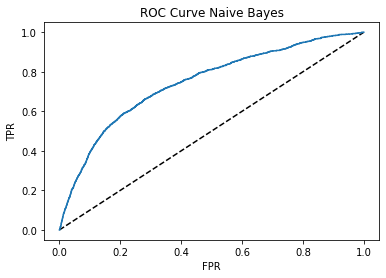

AUC:  0.7440924291840554


In [313]:
probas = gnb.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Naive Bayes')
plt.show()

print("AUC: " ,roc_auc_score(y_test, probas[:, 1]))

In [314]:
y_pred = gnb.predict(X_test)

In [572]:
from sklearn.linear_model import LogisticRegression

In [573]:
logistic = LogisticRegression()

In [574]:
cross_val(logistic, X_train, y_train)

{'accuracy': 0.9771518417513365, 'f1': 0.000746268656716418}

In [319]:
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

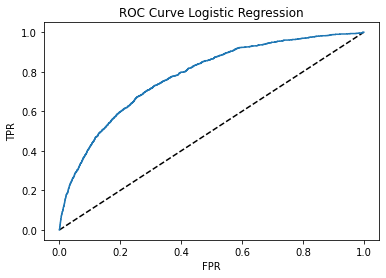

AUC:  0.7787540668900076


In [320]:
probas = logistic.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Logistic Regression')
plt.show()

print("AUC: " ,roc_auc_score(y_test, probas[:, 1]))

Logistic Regression's AUC is slightly higher than Naive-Bayes. 

### Regression

In [576]:
X_arr,names = backwardElimination(X, y2, 0.05)  # significance level = 0.05

In [577]:
X_be = pd.DataFrame(X_arr)

In [578]:
X_be.columns = names

In [579]:
VIF_check(X_be)

,feature,VIF
0,explicit,1.222781
1,danceability,22.243099
2,energy,25.475433
3,loudness,10.263265
4,mode,2.703594
5,speechiness,1.705686
6,acousticness,3.624616
7,instrumentalness,1.315678
8,liveness,2.516456
9,valence,9.474510


Here, now using continuous target variable (popularity) for Regression, feature selection dropped song duration. We will drop time signature again.  

In [580]:
X_be = X_be.drop(['time_signature'],axis=1)

In [581]:
VIF_check(X_be)

,feature,VIF
0,explicit,1.222374
1,danceability,17.453047
2,energy,16.604176
3,loudness,7.848273
4,mode,2.669179
5,speechiness,1.663877
6,acousticness,3.310791
7,instrumentalness,1.307687
8,liveness,2.511678
9,valence,9.100718


In [582]:
X_be["Explicit"] = X_be["explicit"]
X_be["mode (major/minor)"] = X_be["mode"]

In [583]:
X_be = X_be.drop(['explicit'],axis=1)
X_be = X_be.drop(['mode'],axis=1)

#### Train Test split

In [584]:
X_train, X_test, y_train, y_test = train_test_split(X_be, y2, test_size = 0.2, random_state = 0)

In [585]:
scaler = StandardScaler()

In [586]:
X_train.iloc[:, 0:9] = scaler.fit_transform(X_train.iloc[:, 0:9])
X_test.iloc[:, 0:9] = scaler.fit_transform(X_test.iloc[:, 0:9])

In [467]:
from sklearn.ensemble import RandomForestRegressor

In [468]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [469]:
rf = RandomForestRegressor(random_state=0)

In [470]:
tuning_parameters = {'n_estimators': [8,10,30], 'max_depth': [9,12]}

search = GridSearchCV(rf, tuning_parameters, cv=5, n_jobs=-1)
results = search.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators=results.best_params_['n_estimators'],
                           max_depth=results.best_params_['max_depth'],random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


KeyboardInterrupt: 

In [482]:
rf = RandomForestRegressor(n_estimators=60,
                           max_depth=30,random_state=0,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [476]:
def model_eval(y_test,y_pred,X_train):    
    'model evaluation metrices'
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    adj_r2 =1-(1-r2_score(y_test, y_pred))*(len(X_train)-1)/(len(X_train)-11-1)
    model_metrices = [mse, rmse, adj_r2]    
    print("The model performance for testing set")
    print("--------------------------------------")
    print('MSE: {}'.format(mse))
    print('RMSE: {}'.format(rmse))
    print('Adjusted R2 score: {}'.format(adj_r2))    
    return model_metrices

In [483]:
model_eval(y_test,y_pred,X_train)

The model performance for testing set
--------------------------------------
MSE: 178.14341880128003
RMSE: 13.3470378287199
Adjusted R2 score: 0.17776531442710153


[178.14341880128003, 13.3470378287199, 0.17776531442710153]

In [271]:
def histogram_(error,color):
    plt.hist(error,color=color)
    plt.suptitle("Error (Test - Predicted)")

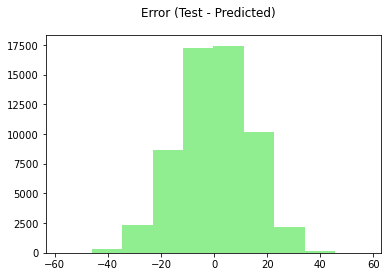

In [481]:
error = y_pred-y_test
histogram_(error,color = "lightgreen")


In [484]:
def actualVSpredicted(y_pred, y_test, model_type):
    'plot models accuracy - predicted vs test data'
    fig, ax = plt.subplots()
    ax.scatter(y_pred, y_test, edgecolors=(0, 0, 1))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    fig.suptitle('Actual vs Predicted - '+ model_type, fontsize=15)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

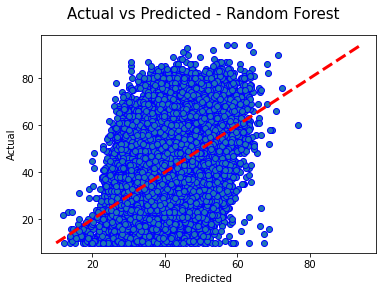

In [485]:
actualVSpredicted(y_pred, y_test,'Random Forest')

In [486]:
from sklearn.neighbors import KNeighborsRegressor

In [491]:
def knn_model(X_train,X_test,y_train,y_test):
    'K-NN Model'
    scores = []
    for i in range(1,10):
        knn = KNeighborsRegressor(n_neighbors=i, metric='minkowski', p=2) # number of neigbours set by iterator i
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred)
        scores.append(rmse)
    return scores, y_pred

In [521]:
def plot_eval_rmse(model_name, parameter, mean_rmse, std_rmse):
    'Plot hyper parameter evaluation for model'
    fig, ax = plt.subplots()
    ax.plot(mean_rmse.index,mean_rmse.values)
    ax.fill_between(mean_rmse.index, mean_rmse.values-std_rmse, mean_rmse.values+std_rmse, color='b', alpha=.1)
    plt.title(model_name)
    plt.xlabel("Value of {}".format(parameter))
    plt.ylabel("mean rmse")
    plt.xticks(rotation=45) 

In [492]:
rmse_Scores_knn, y_pred = knn_model(X_train,X_test,y_train,y_test)

In [495]:
mean_rmse_knn, std_rmse_knn= statistics.mean(rmse_Scores_knn), statistics.stdev(rmse_Scores_knn)

In [497]:
dic_scores = {'mean': mean_rmse_knn, 'std': std_rmse_knn}

In [498]:
rmse_scores_knn = pd.concat([pd.Series(v, name=k) for k, v in dic_scores.items()],axis=1)

In [501]:
rmse_Scores = rmse_Scores_knn

[330.75012389562005,
 254.08903395594442,
 228.8824292275939,
 216.13108263410632,
 208.34877249346346,
 203.45608825925228,
 199.8938086368064,
 197.29882448690125,
 195.55721445936257]

Text(0.5, 1.0, 'K parameter tuning - KNN Regressor')

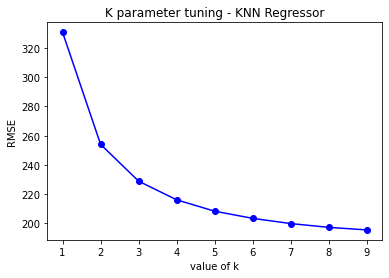

In [520]:
plt.plot(range(1,10), rmse_Scores_knn,'ob-')
plt.xlabel('value of k')
plt.ylabel('RMSE')
plt.title('K parameter tuning - KNN Regressor')

As we check more K values, RMSE decreases. Only the problem with Knn is the very slow runtime.  

Rule of thumb for K-NN: We want to choose the k value corresponding to the part of the graph where the line breaks (the "elbow"), so the model won't be overfit (can happen if we take the lowest k value). 

We will choose k = 4.

In [587]:
knn = KNeighborsRegressor(n_neighbors=4, metric='minkowski', p=2)

In [588]:
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=4)

In [589]:
y_pred = knn.predict(X_test)

In [594]:
r2_score(y_test, y_pred)

0.00247720397200879